In [1]:
import seaborn as sns 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./creditcard.csv')
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


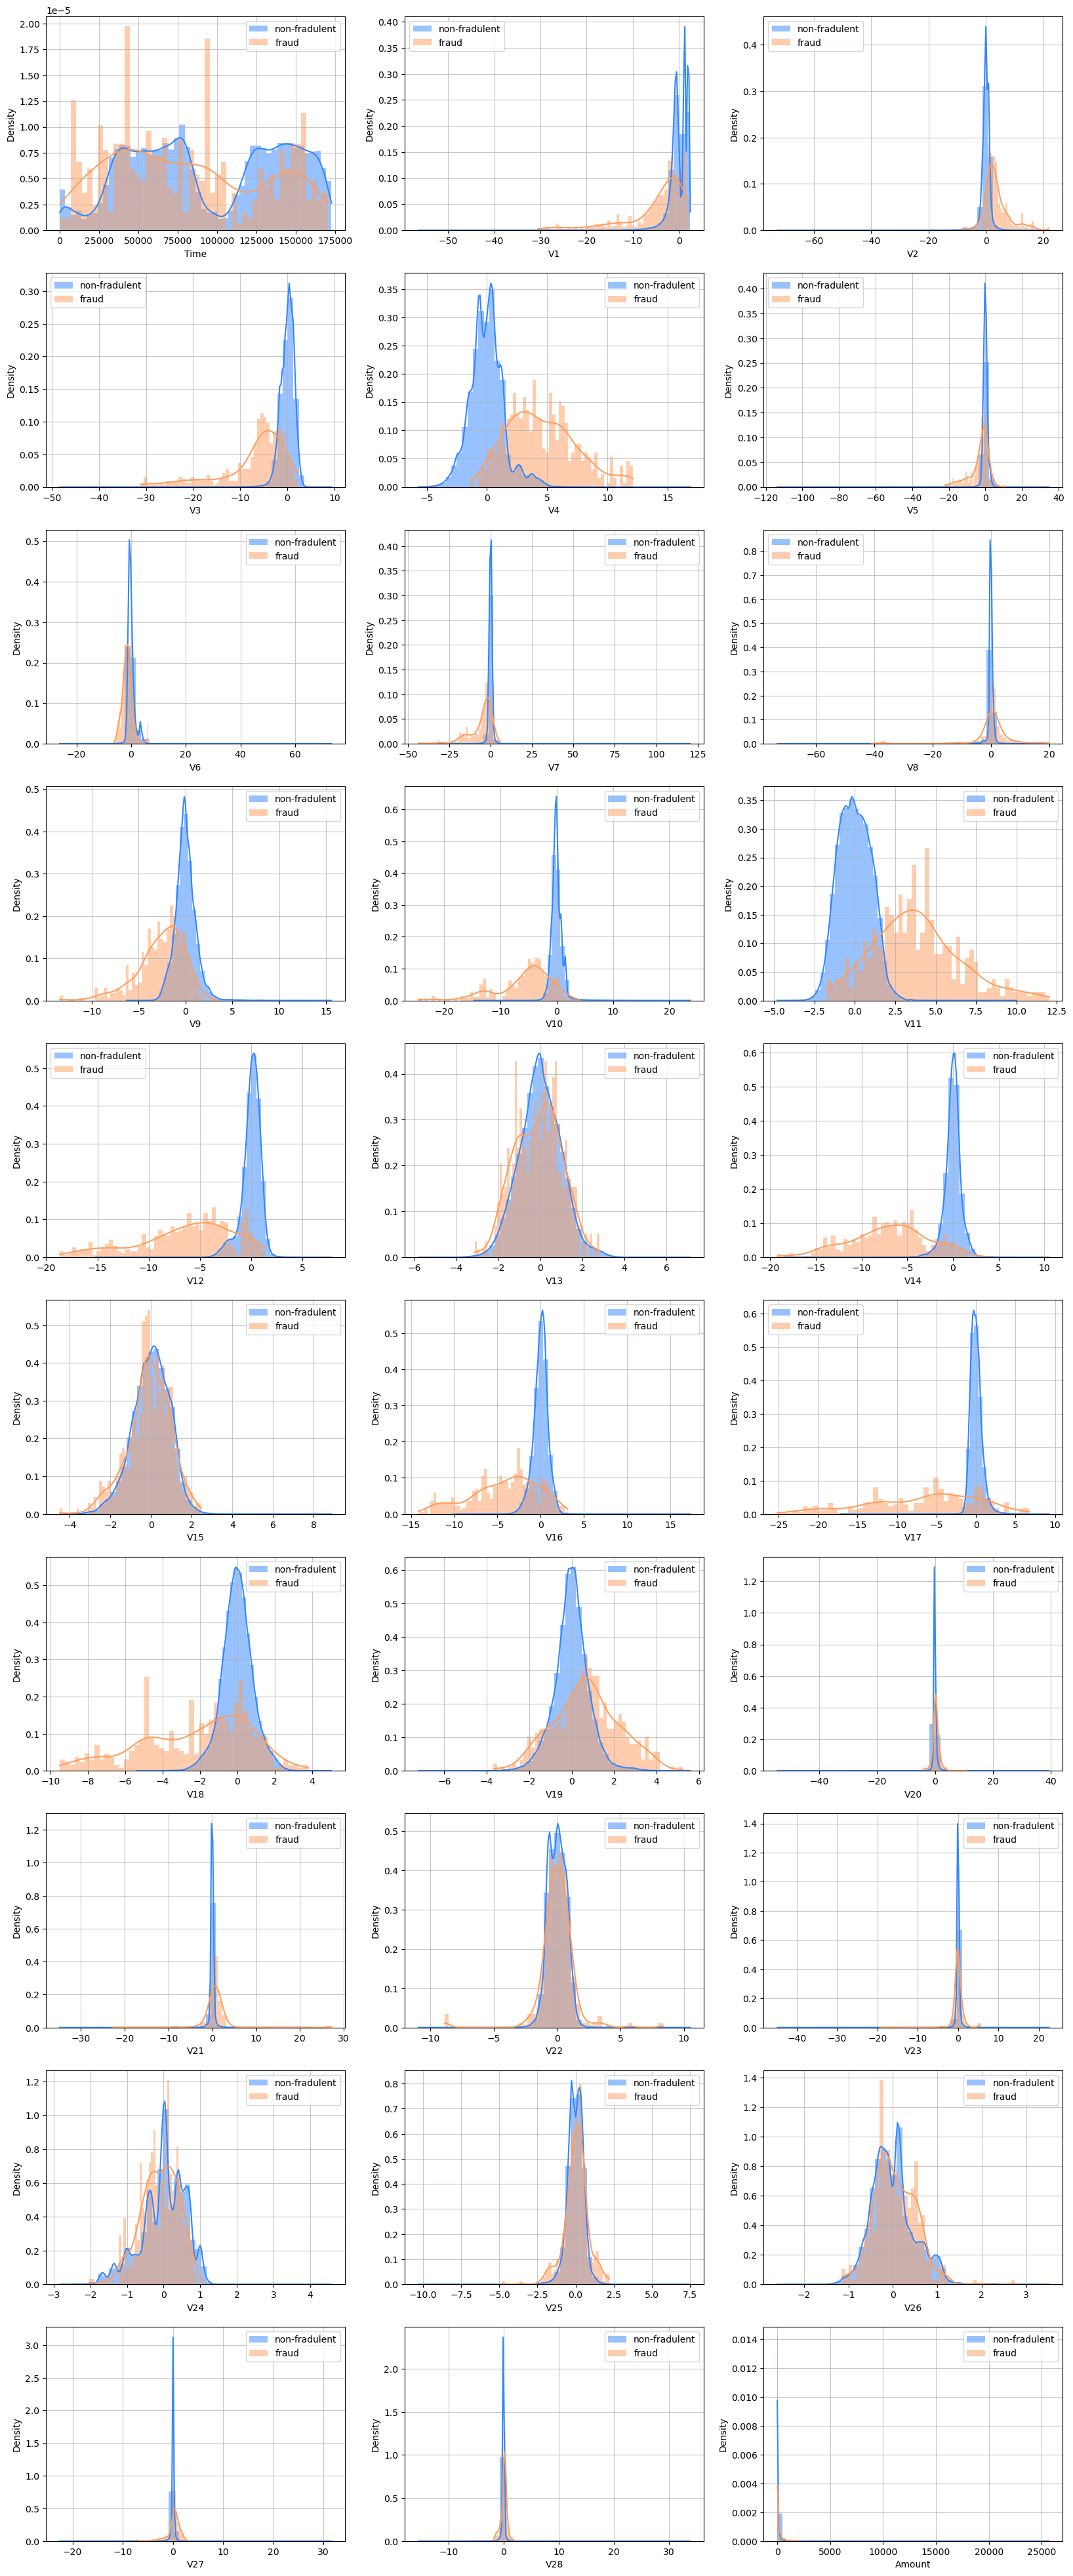

In [3]:
numeric_columns = (list(df.loc[:, 'Time':'Amount']))

# graph each feature distribution
plt.rcParams['patch.edgecolor'] = 'none'
fig = plt.figure(figsize=(20, 50))
rows, cols = 10, 3
for idx, num in enumerate(numeric_columns[:30]):
    ax = fig.add_subplot(rows, cols, idx+1)
    ax.grid(alpha = 0.7, axis ="both")
    sns.histplot(x=num, color ="#3386FF",linewidth=0.6, data = df[df['Class'] == 0], label='non-fradulent', bins=50, kde=True, stat="density")
    sns.histplot(x=num, color ="#FF9D5C",linewidth=0.6, data = df[df['Class'] == 1], label='fraud', bins=50, kde=True, stat="density")  
    ax.set_xlabel(num)
    ax.legend()
fig.show()

In [4]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

In [5]:
x = df.drop('Class', axis=1)
y = df.Class

In [6]:
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
#concat two dataframes
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

   Specs         Score
17   V17  33979.168593
14   V14  28695.547788
12   V12  20749.822361
10   V10  14057.979985
16   V16  11443.349428
3     V3  11014.508305
7     V7  10349.605408
11   V11   6999.355047
4     V4   5163.832114
18   V18   3584.380605


In [7]:
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
#concat two dataframes
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

   Specs     Score
17   V17  0.008258
14   V14  0.008136
12   V12  0.007601
10   V10  0.007530
11   V11  0.006831
16   V16  0.006144
4     V4  0.004976
3     V3  0.004952
18   V18  0.004317
9     V9  0.004277


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
df = df[['V17','V14','V12','V10','V16','V3','V7','V11','V4', 'V18', 'Class']]

In [10]:
# split into train, valid, and test set
# train - 80% non-fraud
# valid - 10% non-fraud, 50% fraud
# test - 10% non-fraud, 50% fraud
all_non_fraud = df[df['Class'] == 0]
all_fraud = df[df['Class'] == 1]

In [11]:
train, other = train_test_split(all_non_fraud, train_size=0.8, random_state=0)

In [12]:
valid_fraud, test_fraud = train_test_split(all_fraud, train_size=0.5, random_state=0)

In [13]:
valid_non_fraud, test_non_fraud = train_test_split(other, train_size=0.5, random_state=0)

In [14]:
valid = pd.concat([valid_fraud, valid_non_fraud], axis=0)

In [15]:
test = pd.concat([test_fraud, test_non_fraud], axis=0)

In [16]:
from scipy.stats import multivariate_normal

In [17]:
# calculate distribution statics
def calculate_gauss_param(df):
    mu = df.mean()
    cov = np.cov(df.T)
    return mu, cov

In [18]:
mu, cov = calculate_gauss_param(train.drop('Class', axis=1))

In [19]:
# make distribution based on statics
def multivariateGaussian(df, mu, cov):
    p = multivariate_normal(mean=mu, cov=cov)
    return p.pdf(df)

In [20]:
p = multivariateGaussian(train.drop(['Class'], axis=1), mu, cov)

In [21]:
p_valid = multivariateGaussian(valid.drop(['Class'], axis=1),mu,cov)

In [22]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score , average_precision_score
from sklearn.metrics import precision_score, precision_recall_curve

In [23]:
# find the best probability threshold for anomaly
# graph F1, precision, and recall for all epsilon tested
def selectThresholdByCV(probs,gt):
    best_epsilon = 0
    best_avg_score = 0
    f = 0
    farray = []
    Recallarray = []
    Precisionarray = []
    epsilons = (0.0000e+00, 1.0527717316e-80,  1.0527717316e-70, 1.0527717316e-60, 1.0527717316e-50, 1.0527717316e-40, 1.0527717316e-30, 1.0527717316e-20, 1.0527717316e-10)
    for epsilon in epsilons:
        predictions = (probs < epsilon)
        avg_score = average_precision_score(y_true=gt, y_score=predictions)
        Recall = recall_score(gt, predictions, average = "binary")
        Precision = precision_score(gt, predictions, average = "binary")
        farray.append(avg_score)
        Recallarray.append(Recall)
        Precisionarray.append(Precision)
        print ('For below Epsilon')
        print(epsilon)
        print ('F1 score , Recall and Precision are as below')
        print ('Best avg_score Score %f' %avg_score)
        print ('Best Recall Score %f' %Recall)
        print ('Best Precision Score %f' %Precision)
        print ('-'*40)
        if avg_score > best_avg_score:
            best_avg_score = avg_score
            best_recall = Recall
            best_precision = Precision
            best_epsilon = epsilon   
    # AUPRC plot
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.5, 0.7, 0.3])
    plt.plot(farray ,"ro")
    plt.plot(farray)
    ax.set_xticks(range(9))
    ax.set_xticklabels(epsilons,rotation = 60 ,fontsize = 'medium' )
    ax.set_ylim((0,1.0))
    ax.set_title('AUCPRC score vs Epsilon value')
    # ax.annotate('Best AUCPRC Score', xy=(best_epsilon,best_avg_score), xytext=(best_epsilon,best_avg_score))
    plt.xlabel("Epsilon value") 
    plt.ylabel("AUCPRC Score") 
    plt.show()
    
    # recall plot
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.5, 0.9, 0.3])
    plt.plot(Recallarray ,"ro")
    plt.plot(Recallarray)
    ax.set_xticks(range(9))
    ax.set_xticklabels(epsilons,rotation = 60 ,fontsize = 'medium' )
    ax.set_ylim((0,1.0))
    ax.set_title('Recall vs Epsilon value')
    #ax.annotate('Best Recall Score', xy=(best_epsilon,best_recall), xytext=(best_epsilon,best_recall))
    plt.xlabel("Epsilon value") 
    plt.ylabel("Recall Score") 
    plt.show()
    
    # precision plot
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.5, 0.9, 0.3])
    plt.plot(Precisionarray ,"ro")
    plt.plot(Precisionarray)
    ax.set_xticks(range(9))
    ax.set_xticklabels(epsilons,rotation = 60 ,fontsize = 'medium' )
    ax.set_ylim((0,1.0))
    ax.set_title('Precision vs Epsilon value')
    #ax.annotate('Best Precision Score', xy=(best_epsilon,best_precision), xytext=(best_epsilon,best_precision))
    plt.xlabel("Epsilon value") 
    plt.ylabel("Precision Score") 
    plt.show()
    return best_avg_score, best_epsilon

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For below Epsilon
0.0
F1 score , Recall and Precision are as below
Best avg_score Score 0.008578
Best Recall Score 0.000000
Best Precision Score 0.000000
----------------------------------------
For below Epsilon
1.0527717316e-80
F1 score , Recall and Precision are as below
Best avg_score Score 0.698328
Best Recall Score 0.719512
Best Precision Score 0.967213
----------------------------------------
For below Epsilon
1.0527717316e-70
F1 score , Recall and Precision are as below
Best avg_score Score 0.731034
Best Recall Score 0.760163
Best Precision Score 0.958974
----------------------------------------
For below Epsilon
1.0527717316e-60
F1 score , Recall and Precision are as below
Best avg_score Score 0.743733
Best Recall Score 0.780488
Best Precision Score 0.950495
----------------------------------------
For below Epsilon
1.0527717316e-50
F1 score , Recall and Precision are as below
Best avg_score Score 0.714815
Best Recall Score 0.796748
Best Precision Score 0.894977
--------------

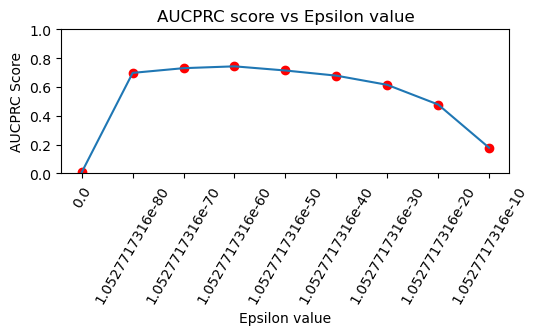

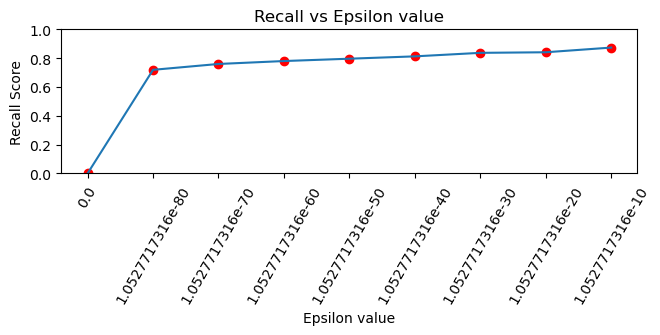

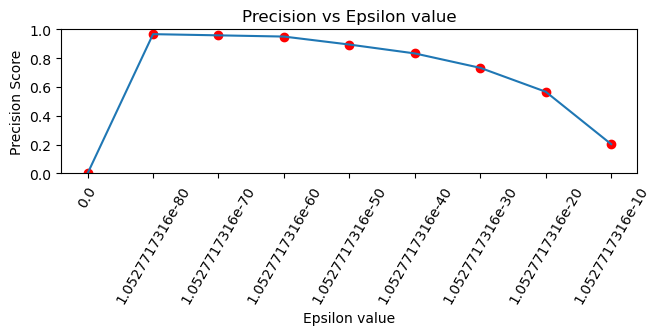

In [24]:
fscore, ep= selectThresholdByCV(p_valid, valid.Class)

In [25]:
ep

1.0527717316e-60

In [26]:
p_test = multivariateGaussian(test.drop(['Class'], axis=1),mu,cov)

In [27]:
# probility < epsilon is anomaly
predictions = (p_test < ep)

# calculate metrics
Recall = recall_score(test.Class, predictions, average = "binary")    
Precision = precision_score(test.Class, predictions, average = "binary")
avg_score = average_precision_score(y_true=test.Class, y_score=predictions)

print ('F1 score , Recall and Precision for Test dataset')
print ('Best avg_score Score %f' %avg_score)
print ('Best Recall Score %f' %Recall)
print ('Best Precision Score %f' %Precision)

F1 score , Recall and Precision for Test dataset
Best avg_score Score 0.724849
Best Recall Score 0.772358
Best Precision Score 0.935961


In [28]:
from sklearn.metrics import roc_auc_score

In [29]:
roc_auc_score(test.Class, predictions)

0.8859502461442735

In [30]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test.Class, predictions)

<Axes: >

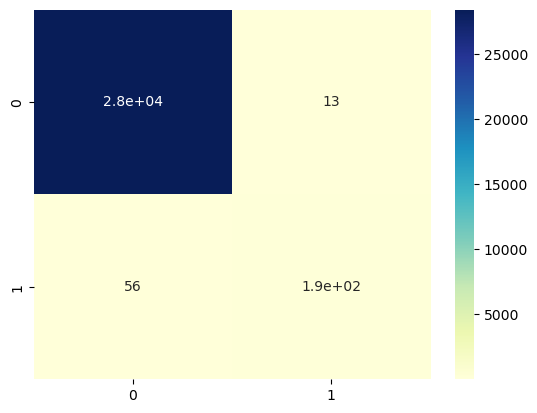

In [31]:
sns.heatmap(cf_matrix, annot=True, cmap='YlGnBu')

In [32]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, average_precision_score
auprc = average_precision_score(y_true=test.Class, y_score=predictions)

In [33]:
auprc

0.7248491078934391